In [1]:
%load_ext lab_black
# use for 3d draw
# %matplotlib widget
# use for imshow
%matplotlib inline
import json
import struct

import h5py
import mat73
import matplotlib.pyplot as plt
import numpy as np
import pytorch3d
import sparseconvnet as scn
import torch
from basicsr.data.events_cls_dataset import EventsClsDataset
from basicsr.data.events_sr_dataset import EventsSRDataset
from dv import LegacyAedatFile
from pytorch3d.ops import (
    add_points_features_to_volume_densities_features,
    knn_gather,
    sample_farthest_points,
)
from scipy.io import loadmat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [2]:
def get_events_visuals(events, h=180, w=240):
    im = np.zeros([h, w])
    for i in events[0]:
        y, x = int(i[1] * h), int(i[0] * w)
        if int(i[3]) == 1:
            im[y, x] += 1
        else:
            im[y, x] -= 1
    im = ((np.sign(im) + 1) / 2.0 * 255.0).astype(np.uint8)
    return im

In [3]:
def get_events_visuals_3d(events):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    events = events[0].detach().cpu().numpy()
    ax.scatter3D(
        events[:, 2], events[:, 0], events[:, 1], c=events[:, 3], cmap="rainbow"
    )
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_zlabel("y")

### visualize asl_dvs

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
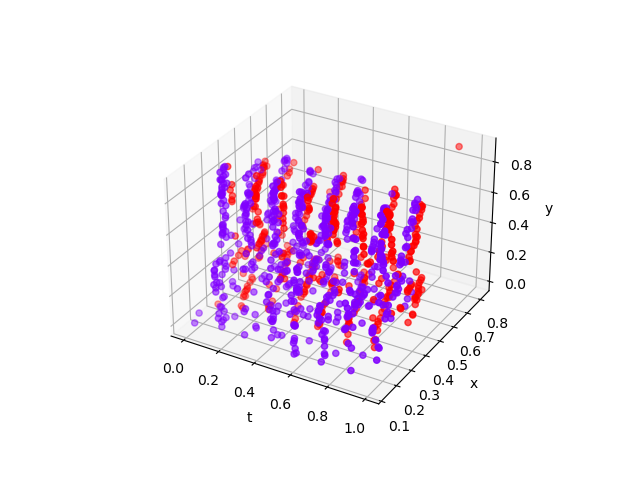

In [8]:
opt = {
    "h5": "/lzh/datasets/DVS/ASL-DVS/asl_dvs.h5",
    "labels": "/lzh/datasets/DVS/ASL-DVS/train.json",
    "sample_fn": "crop",
    "sample_num": 1024,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
# im = get_events_visuals(events)
# plt.imshow(im, cmap="gray")
# plt.draw()
get_events_visuals_3d(events)

### visualize cifar10

In [21]:
opt = {
    "h5": "/lzh/datasets/DVS/CIFAR10-DVS/cifar10_dvs.h5",
    "labels": "/lzh/datasets/DVS/CIFAR10-DVS/train.json",
    "sample_fn": "all",
    "sample_num": -1,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
print(events.shape)
# im = get_events_visuals(events, 128, 128)
# plt.imshow(im, cmap="gray")
# plt.draw()
# get_events_visuals_3d(events)

torch.Size([1, 241550, 4])


### visualize n-cars

tensor([0]) ['train_car_obj_009044_td.dat'] torch.Size([1, 1134, 4]) tensor([[  0.,  53.,  73.,  73., 233., 252., 253., 253., 348., 540.]]) tensor([[98999., 99156., 99350., 99430., 99718., 99777., 99786., 99788., 99904.,
         99906.]])


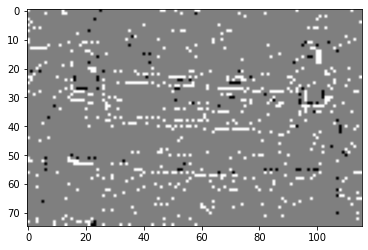

In [38]:
opt = {
    "h5": "/lzh/datasets/DVS/N-CARS/Prophesee_Dataset_n_cars/n_cars.h5",
    "labels": "/lzh/datasets/DVS/N-CARS/Prophesee_Dataset_n_cars/train.json",
    "sample_fn": "all",
    "sample_num": 2048,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
with h5py.File("/lzh/datasets/DVS/N-CARS/Prophesee_Dataset_n_cars/n_cars.h5", "r") as f:
    size = json.loads(f[str(key[0]) + "_pos"].attrs["size"])
im = get_events_visuals(events, size["height"] - 1, size["width"] - 1)
print(gt, key, events.shape, events[:, :10, 2], events[:, -10:, 2])
plt.imshow(im, cmap="gray")
plt.draw()

### visualize n-caltech101

{'height': 173, 'width': 151} torch.Size([1, 4096, 4])


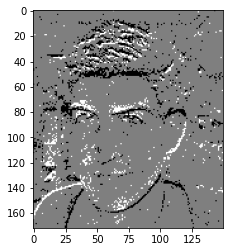

In [62]:
opt = {
    "h5": "/lzh/datasets/DVS/N-Caltech101/caltech101.h5",
    "labels": "/lzh/datasets/DVS/N-Caltech101/test.json",
    "sample_fn": "crop",
    "sample_num": 4096,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
with h5py.File("/lzh/datasets/DVS/N-Caltech101/caltech101.h5", "r") as f:
    size = json.loads(f[str(key[0]) + "_pos"].attrs["size"])
print(size, events.shape)
im = get_events_visuals(events, size["height"] - 1, size["width"] - 1)
plt.imshow(im, cmap="gray")
plt.draw()

### visualize event zoom

3072 17536 ['ev_lr_2_75.txt']
5.708333333333333


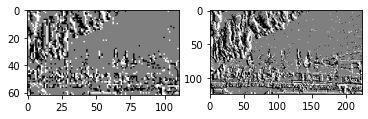

In [259]:
opt = {
    "h5": "/lzh/datasets/DVS/EventZoom/eventzoom.h5",
    "maplist": "/lzh/datasets/DVS/EventZoom/eventzoom.map.h5",
    "labels": "/lzh/datasets/DVS/EventZoom/test_2x.json",
    "sample_fn": "crop",
    "sample_num": 3072,
}

dataset = EventsSRDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
data = next(iter(dataloader))
lq, gt, key = data["lq"], data["gt"], data["key"]
lq_im = get_events_visuals(lq, 62, 111)
# lq_im = get_events_visuals(lq, 31, 56)
gt_im = get_events_visuals(gt, 124, 224)
print(lq.shape[1], gt.shape[1], key)
print(float(gt.shape[1] / lq.shape[1]))
plt.subplot(121)
plt.imshow(lq_im, cmap="gray")
plt.subplot(122)
plt.imshow(gt_im, cmap="gray")
plt.draw()

### load cifar10 from aedat2

In [ ]:
dv_path = "/lzh/datasets/DVS/CIFAR10-DVS/horse/cifar10_horse_793.aedat"
im = np.zeros([128, 128])
with open(dv_path, "rb") as f:
    # skip header
    last_pos = 0
    line = f.readline()
    while line.startswith(b"#"):
        last_pos = f.tell()
        line = f.readline(10000)
    f.seek(last_pos, 0)
    # read events
    tsoverflow = 0
    last_timestamp32 = -1
    counter = 0
    while True:
        data = f.read(8)
        if not data:
            break
        address = struct.unpack(">I", data[0:4])[0]
        timestamp32 = struct.unpack(">I", data[4:8])[0]

        polarity = address & 0x1
        polarity = 1 - polarity
        y = (address & 0x7F00) >> 8
        x = (address & 0xFE) >> 1
        x, y = 127 - x, 127 - y
        if timestamp32 < last_timestamp32:
            tsoverflow += 1

        last_timestamp32 = timestamp32
        timestamp = timestamp32 | tsoverflow << 31

        if polarity:
            im[y, x] += 1
        else:
            im[y, x] -= 1

        counter += 1
im = np.sign(im)
im = (im + 1) / 2.0 * 255.0
plt.imshow(im, cmap="gray")
plt.draw()

### load n-cars from dat

In [ ]:
dv_path = "/lzh/datasets/DVS/N-CARS/Prophesee_Dataset_n_cars/n-cars_train/cars/obj_007481_td.dat"
im = np.zeros([71, 83])
with open(dv_path, "rb") as f:
    # skip header
    last_pos = 0
    line = f.readline()
    while line.startswith(b"%"):
        last_pos = f.tell()
        line = f.readline(10000)
    f.seek(last_pos, 0)
    # read evType and evSize
    f.read(2)
    # read events
    counter = 0
    while True:
        data = f.read(8)
        if not data:
            break
        timestamp32 = struct.unpack("<I", data[0:4])[0]
        address = struct.unpack("<I", data[4:8])[0]

        polarity = (address & 0x10000000) >> 28
        y = (address & 0xFFFC000) >> 14
        x = address & 0x3FFF
        timestamp = timestamp32
        if polarity:
            im[y, x] += 1
        else:
            im[y, x] -= 1
        counter += 1
im = np.sign(im)
im = (im + 1) / 2.0 * 255.0
plt.imshow(im, cmap="gray")
plt.draw()

### load n-mnist

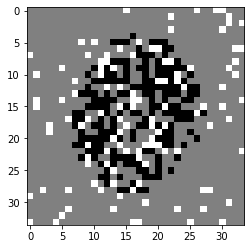

In [2]:
bin_path = "/lzh/datasets/DVS/N-MNIST/Test/0/00004.bin"
im = np.zeros([34, 34])
with open(bin_path, "rb") as f:
    # read events
    counter = 0
    while True:
        data = f.read(5)
        if not data:
            break
        x = data[0]
        y = data[1]
        polarity = data[2] >> 7
        polarity = (polarity - 0.5) / 0.5
        timestamp = (data[2] & 127) << 16
        timestamp += data[3] << 8
        timestamp += data[4]
        counter += 1
        im[y, x] += polarity
im = np.sign(im)
im = (im + 1) / 2.0 * 255.0
plt.imshow(im, cmap="gray")
plt.draw()

### convert h5 to maplist

In [ ]:
def _h5_to_maplist(h5_path, lq_key, gt_key):
    step, ratio = 64, 20
    read_file = h5py.File(h5_path, "r")
    map_list = np.zeros(read_file[lq_key].shape[0], dtype=np.uint32)
    pbar = tqdm(total=read_file[lq_key].shape[0] // step, unit="event", desc=lq_key)
    lq_dataset = read_file[lq_key]
    gt_dataset = read_file[gt_key]
    gt_start_id = 0
    for i in range(0, lq_dataset.shape[0], step):
        lq_start_id, lq_stop_id = i, min(i + step, lq_dataset.shape[0])
        gt_stop_id = min(gt_start_id + step * ratio, gt_dataset.shape[0])
        lq_ts = lq_dataset[lq_start_id:lq_stop_id].astype(np.int64)[:, None]
        gt_ts = gt_dataset[gt_start_id:gt_stop_id].astype(np.int64)[None, :]
        index = gt_start_id + np.argmin(np.abs(lq_ts - gt_ts), axis=1)
        map_list[lq_start_id:lq_stop_id] = index
        gt_start_id = int(index.max())
        pbar.update(1)
    read_file.close()
    print(map_list[-step:])


_h5_to_maplist(
    "/lzh/datasets/DVS/EventZoom/eventzoom.h5",
    "ev_lr_2_97.txt_timestamps",
    "ev_hr_97.txt_timestamps",
)

### convert h5 to voxel

In [ ]:
def _h5_to_voxel(h5_path, k, time_resolution=10000):
    read_file = h5py.File(h5_path, "r")
    total_frames = (read_file[k][-1] - read_file[k][0]) // time_resolution
    if total_frames * time_resolution < (read_file[k][-1] - read_file[k][0]):
        total_frames += 1
    h, w = 62, 111
    voxel = np.zeros([total_frames, h, w], dtype=np.int16)
    annotations = [
        {"start_id": 0, "stop_id": read_file[k].shape} for _ in range(total_frames)
    ]
    start_t, counter = float(read_file[k][0]), 0
    for i, t in enumerate(read_file[k]):
        t = float(t)
        if t - start_t > time_resolution:
            start_t = t
            annotations[counter]["stop_id"] = i
            counter += 1
            annotations[counter]["start_id"] = i
        x, y = read_file[k.replace("timestamps", "pos")][i]
        e = read_file[k.replace("timestamps", "events")][i]
        if e:
            voxel[counter, y, x] += 1
        else:
            voxel[counter, y, x] -= 1
    voxel = voxel[: counter + 1]
    annotations = annotations[: counter + 1]


_h5_to_voxel("/lzh/datasets/DVS/EventZoom/eventzoom.h5", "ev_lr_2_97.txt_timestamps")

### load data from eventzoom voxel

(3757, 124, 222) (3532, 31, 56)


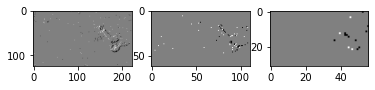

In [124]:
with h5py.File("/lzh/datasets/DVS/EventZoom/eventzoom.voxel.h5", "r") as f:
    hr = f["ev_hr_1.txt"]
    lr = f["ev_lr_1_1.txt"]
    llr = f["ev_llr_1_1.txt"]
    print(hr.shape, llr.shape)
    hr = hr[200 : 200 + 1].sum(0)
    lr = lr[200 : 200 + 1].sum(0)
    llr = llr[200 : 200 + 1].sum(0)
plt.subplot(131)
plt.imshow(np.sign(hr), cmap="gray")
plt.subplot(132)
plt.imshow(np.sign(lr), cmap="gray")
plt.subplot(133)
plt.imshow(np.sign(llr), cmap="gray")
plt.draw()

In [23]:
mat = "/lzh/datasets/DVS/DVSNOISE20/5_epm/alley-2019_11_04_09_36_15_epm_array.mat"
epm = mat73.loadmat(mat)["epm"]
mat = mat.replace("_epm_array", "").replace("5_epm", "2_mat")
aedat = loadmat(mat)["aedat"][0, 0]
events = aedat[0][0][0][0][0][0]
frame = aedat[0][0][0][1][0][0]
polarity = events[0][0]
timestamps = events[1][0]
x = events[2][0]
y = events[3][0]
total_num = events[4][0][0]

AttributeError: 'str' object has no attribute 'keys'

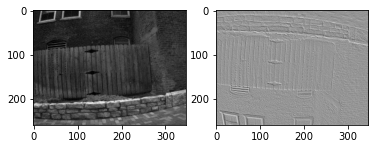

In [58]:
samples = frame[0]
position = frame[1]
sizeAll = frame[2]
timestamps = frame[3][0]
frame_start = frame[4][0]
frame_end = frame[5][0]
exp_start = frame[6]
exp_end = frame[7]
num_diff_images = frame[8]
size = frame[9]
plt.subplot(121)
plt.imshow(samples[:, :, 3], cmap="gray")
plt.subplot(122)
plt.imshow(epm[:, :, 0], cmap="gray")
plt.draw()

In [63]:
features = loadmat(
    "/lzh/datasets/DVS/DVSNOISE20/6_features/alley-2019_11_04_09_36_15_labels.mat"
)
x = features["X"]
y = features["Y_paper"][:, 0]
pol = features["pol"][0]
samples = features["samples"][:, 0]

(25, 25, 8, 10000)


0.0 10.407669


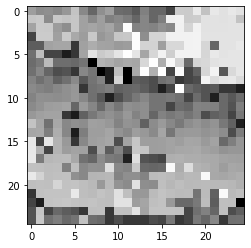

In [68]:
print(x.min(), x.max())
plt.imshow(x[:, :, 0, 0], cmap="gray")
plt.draw()

In [30]:
# mat = "/lzh/datasets/DVS/DVSNOISE20/all_labels.mat"
mat = "/lzh/Project/edncnn/edncnn_output/all_labels.mat"
mat = mat73.loadmat(mat)
print(mat.keys())
print(mat["grpLabel"].min(), mat["grpLabel"].max(), mat["grpLabel"].mean())

dict_keys(['X', 'Y', 'grpLabel', 'setLabel'])
1.0 16.0 8.5


In [34]:
a = mat["grpLabel"]
b = mat["grpLabel"] == 1
print(~b)
temp = mat["X"][:, :, :, mat["grpLabel"] == 1]
print(temp.shape)

[False False False ...  True  True  True]
(25, 25, 8, 30000)


In [22]:
mat["setLabel"].shape

(480000,)

In [24]:
mat = "/lzh/datasets/DVS/DVSNOISE20/5_epm/alley-2019_11_04_09_36_15_epm_array.mat"
print(mat73.loadmat(mat).keys())

dict_keys(['epm'])


In [110]:
with h5py.File("/lzh/datasets/DVS/EventZoom/eventzoom.map.h5", "r") as f:
    maplist = f["ev_llr_1_24.txt"][:]

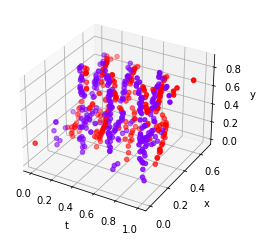

In [8]:
opt = {
    "h5": "/lzh/datasets/DVS/ASL-DVS/asl_dvs.h5",
    "labels": "/lzh/datasets/DVS/ASL-DVS/train.json",
    "sample_fn": "crop",
    "sample_num": 512,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
# im = get_events_visuals(events)
# plt.imshow(im, cmap="gray")
# plt.draw()
get_events_visuals_3d(events)

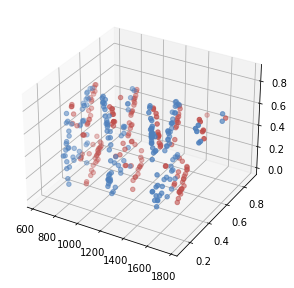

In [87]:
import cv2
from cv2 import resize
from matplotlib.colors import ListedColormap

with h5py.File("/lzh/datasets/DVS/ASL-DVS/asl_dvs.h5", "r") as f:
    key = "v_3384.mat"
    size = np.array([240, 180])
    start_id, stop_id = 150, 500
    events = np.zeros([stop_id - start_id, 4], dtype=np.float32)
    events[:, :2] = f[key + "_pos"][start_id:stop_id].astype(np.float32) / size
    events[:, 2] = f[key + "_timestamps"][start_id:stop_id].astype(np.float32)
    # events[:, 2] = (events[:, 2] - events[0, 2]) / (events[-1, 2] - events[0, 2])
    events[:, 3] = f[key + "_events"][start_id:stop_id]


red = np.array([192, 80, 77, 255.0]) / 255.0
blue = np.array([79, 129, 189, 255.0]) / 255.0
h, w = 180, 240


def draw3D(events):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(
        events[:, 2],
        events[:, 0],
        events[:, 1],
        c=events[:, 3],
        cmap=ListedColormap([blue, red]),
    )
    # plt.axis("off")
    # ax.set_xlabel("T")
    # ax.set_ylabel("X")
    # ax.set_zlabel("Y")
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.savefig("figures/3d.png", transparent=True, dpi=600)


def _draw_bound(pos):
    b = 2
    for i in range(h):
        for j in range(w):
            if i > (h - b) or i < b or j > (w - b) or j < b:
                pos[i, j] = np.array([0, 0, 0, 1])
    return pos


def drawpos(events):
    pos = np.zeros([h, w, 4])
    for i in events:
        x, y, p = int(i[0] * w), h - 1 - int(i[1] * h), int(i[-1])
        if p == 1:
            pos[y - 2 : y + 2, x - 2 : x + 2] = red
    pos = _draw_bound(pos)
    plt.imshow(pos)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("figures/pos.png", transparent=True)


def drawneg(events):
    neg = np.zeros([h, w, 4])
    for i in events:
        x, y, p = int(i[0] * w), h - 1 - int(i[1] * h), int(i[-1])
        if p == 1:
            neg[y - 2 : y + 2, x - 2 : x + 2] = blue
    neg = _draw_bound(neg)
    plt.imshow(neg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("figures/neg.png", transparent=True)


def drawvoxel(events):
    v = 32
    pos, neg = np.zeros([v, v, v]), np.zeros([v, v, v])
    for e in events:
        x, y, t = (
            int(np.round(e[0] * v)),
            int(np.round(e[1] * v)),
            min(int(np.round(e[2] * v)), 15),
        )
        if e[-1] == 1:
            pos[t, x, y] = 1
        else:
            neg[t, x, y] = 1
    pos, neg = pos.astype(np.bool), neg.astype(np.bool)
    voxels = pos | neg
    colors = np.zeros([v, v, v, 4])
    colors[pos] = red
    colors[neg] = blue

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.voxels(voxels, facecolors=colors)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("figures/voxel.png", transparent=True, dpi=600)


def drawframe(events):
    im = np.ones([h, w, 3]) * 0.5
    for i in events:
        x, y, p = int(i[0] * w), h - 1 - int(i[1] * h), int(i[-1])
        if p == 1:
            im[y - 2 : y + 2, x - 2 : x + 2] = 1
        else:
            im[y - 2 : y + 2, x - 2 : x + 2] = 0
    from imageio import imwrite

    imwrite("figures/frame.png", im)


def drawsnn(events):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.set_xlim3d(0, 1)
    ax.set_ylim3d(0, 1)
    ax.set_zlim3d(0, 1)

    pt, px, py = [], [], []
    nt, nx, ny = [], [], []
    for e in events:
        if e[-1] == 1:
            pt.append(e[2]), px.append(e[0]), py.append(e[1])
        else:
            nt.append(e[2]), nx.append(e[0]), ny.append(e[1])
    zero, one = [0 for _ in pt], [1 for _ in pt]
    ax.quiver(pt, px, py, zero, zero, one, length=0.06, color=red, normalize=True)
    zero, one = [0 for _ in nt], [-1 for _ in nt]
    ax.quiver(nt, nx, ny, zero, zero, one, length=0.06, color=blue, normalize=True)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("figures/snn.png", transparent=True, dpi=600)


draw3D(events)
# drawpos(events)
# drawneg(events)
# drawvoxel(events)
# drawframe(events)
# drawsnn(events)

In [238]:
import cv2
from cv2 import resize
from matplotlib.colors import ListedColormap

with h5py.File("/lzh/datasets/DVS/N-MNIST/n_mnist.h5", "r") as f:
    key = "Test_0_03614.bin"
    size = np.array([32, 32])
    start_id, stop_id = 750, 800
    events = np.zeros([stop_id - start_id, 4], dtype=np.float32)
    events[:, :2] = f[key + "_pos"][start_id:stop_id].astype(np.float32) / size
    events[:, 2] = f[key + "_timestamps"][start_id:stop_id].astype(np.float32)
    events[:, 2] = (events[:, 2] - events[0, 2]) / (events[-1, 2] - events[0, 2])
    events[:, 3] = f[key + "_events"][start_id:stop_id]
events[25:, 3] = -1

red = np.array([192, 80, 77, 255.0]) / 255.0
blue = np.array([79, 129, 189, 255.0]) / 255.0
green = np.array([155, 187, 89, 255.0]) / 255.0
purple = np.array([128, 100, 162, 255.0]) / 255.0
sblue = np.array([75, 172, 198, 255.0]) / 255.0


def draw(events, k, cmap):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(
        events[:, 2],
        events[:, 0],
        events[:, 1],
        c=events[:, 3],
        cmap=cmap,
    )
    plt.axis("off")
    plt.xlim(-10, 10)
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(k), transparent=True, dpi=600)
    plt.close()


def drawAtten(events, selected_events, k, c):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(
        events[:, 2],
        events[:, 0],
        events[:, 1],
        c="none",
        marker="o",
        edgecolors=[c for _ in events],
    )
    ax.scatter3D(
        selected_events[:, 2],
        selected_events[:, 0],
        selected_events[:, 1],
        c=selected_events[:, 3],
        cmap=ListedColormap([c, c]),
    )
    plt.axis("off")
    plt.xlim(-10, 10)
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(k), transparent=True, dpi=600)
    plt.close()


def drawE(events):
    draw(events, "E", ListedColormap([blue, red]))


def drawF(events):
    draw(events, "F", "gray")


def drawQ(events):
    draw(events, "Q", ListedColormap([purple, purple]))


def drawK(events):
    draw(events, "K", ListedColormap([green, green]))


def drawV(events):
    draw(events, "V", ListedColormap([sblue, sblue]))


# drawE(events)
# drawF(events)
# drawQ(events)
# drawK(events)
# drawV(events)
selected_events = events[3][None]
drawAtten(events, selected_events, "KK", green)
k = 8
kidx = np.argpartition(np.power(events[:, :3] - selected_events[:, :3], 2).mean(1), k)[
    :k
]
selected_events = events[kidx]
drawAtten(events, selected_events, "QK", purple)
drawAtten(events, selected_events, "VK", sblue)

In [245]:
import cv2
from cv2 import resize
from matplotlib.colors import ListedColormap

h, w = 128, 128
with h5py.File("/lzh/datasets/DVS/N-MNIST/n_mnist.h5", "r") as f:
    key = "Test_0_03614.bin"
    start_id, stop_id = 750, 800
    events = np.zeros([stop_id - start_id, 4], dtype=np.float32)
    events[:, :2] = f[key + "_pos"][start_id:stop_id].astype(np.float32) / np.array(
        [30, 30]
    )
    events[:, 2] = f[key + "_timestamps"][start_id:stop_id].astype(np.float32)
    events[:, 2] = (events[:, 2] - events[0, 2]) / (events[-1, 2] - events[0, 2])
    events[:, 3] = f[key + "_events"][start_id:stop_id]
events[25:, 3] = -1

gray = np.array([30, 30, 30, 255.0]) / 255.0
red = np.array([192, 80, 77, 255.0]) / 255.0
blue = np.array([79, 129, 189, 255.0]) / 255.0
green = np.array([155, 187, 89, 255.0]) / 255.0
purple = np.array([128, 100, 162, 255.0]) / 255.0
sblue = np.array([75, 172, 198, 255.0]) / 255.0


def _draw_bound(im):
    b = 1
    for i in range(h):
        for j in range(w):
            if i > (h - b - 1) or i < b or j > (w - b - 1) or j < b:
                im[i, j] = np.array([0, 0, 0, 1])
    return im


def drawframe(events, tar, k, c):
    im = np.zeros([h, w, 4])
    im[:, :, 3] = 0.1
    for i in events:
        x, y, p = int(i[0] * w), int(i[1] * h), int(i[-1])
        if int(p) in tar:
            im[y - 2 : y + 2, x - 2 : x + 2] = c[tar.index(int(p))]
    im = _draw_bound(im)
    plt.imshow(im)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(k), transparent=True)
    plt.close()


drawframe(events, [1, -1], "Fframe", [red, blue])
drawframe(events, [1, -1], "Eframe", [gray, gray])
drawframe(events, [1], "FPframe", [red])
drawframe(events, [-1], "FNframe", [blue])

drawframe(events, [1, -1], "Qframe", [purple, purple])
drawframe(events, [1, -1], "Kframe", [green, green])
drawframe(events, [1, -1], "Vframe", [sblue, sblue])

selected_events = events[3][None]
drawframe(selected_events, [1, -1], "KKframe", [green, green])
k = 8
kidx = np.argpartition(np.power(events[:, :3] - selected_events[:, :3], 2).mean(1), k)[
    :k
]
selected_events = events[kidx]
drawframe(selected_events, [1, -1], "QKframe", [purple, purple])
drawframe(selected_events, [1, -1], "VKframe", [sblue, sblue])

In [258]:
import cv2
from cv2 import resize
from matplotlib.colors import ListedColormap

with h5py.File("/lzh/datasets/DVS/N-MNIST/n_mnist.h5", "r") as f:
    key = "Test_0_03614.bin"
    size = np.array([32, 32])
    start_id, stop_id = 750, 800
    events = np.zeros([stop_id - start_id, 4], dtype=np.float32)
    events[:, :2] = f[key + "_pos"][start_id:stop_id].astype(np.float32) / size
    events[:, 2] = f[key + "_timestamps"][start_id:stop_id].astype(np.float32)
    events[:, 2] = (events[:, 2] - events[0, 2]) / (events[-1, 2] - events[0, 2])
    events[:, 3] = f[key + "_events"][start_id:stop_id]
events[25:, 3] = -1

red = np.array([192, 80, 77, 255.0]) / 255.0
blue = np.array([79, 129, 189, 255.0]) / 255.0
green = np.array([155, 187, 89, 255.0]) / 255.0
purple = np.array([128, 100, 162, 255.0]) / 255.0
sblue = np.array([75, 172, 198, 255.0]) / 255.0


def draw(events, k, cmap):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(
        events[:, 2],
        events[:, 0],
        events[:, 1],
        c=events[:, 3],
        cmap=cmap,
    )
    plt.axis("off")
    plt.xlim(-10, 10)
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(k), transparent=True, dpi=600)
    plt.close()


def drawAtten(events, selected_events, k, c):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(
        events[:, 2],
        events[:, 0],
        events[:, 1],
        c="none",
        marker="o",
        edgecolors=[c for _ in events],
    )
    ax.scatter3D(
        selected_events[:, 2],
        selected_events[:, 0],
        selected_events[:, 1],
        c=selected_events[:, 3],
        cmap=ListedColormap([c, c]),
    )
    plt.axis("off")
    plt.xlim(-10, 10)
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(k), transparent=True, dpi=600)
    plt.close()


def drawE(events):
    draw(events, "SE", ListedColormap([blue, red]))


def drawF(events):
    draw(events, "SF", "gray")


def drawQ(events):
    draw(events, "SQ", ListedColormap([purple, purple]))


def drawK(events):
    draw(events, "SK", ListedColormap([purple, purple]))


def drawV(events):
    draw(events, "SV", ListedColormap([sblue, sblue]))


sample_events = []
k = 4
for i, e in enumerate(events):
    if i % k == 0 or i == 3:
        sample_events.append(e[None])
events = np.concatenate(sample_events)
drawE(events)
drawF(events)
drawQ(events)
drawK(events)
drawV(events)
selected_events = events[0][None]
k = 8
kidx = np.argpartition(np.power(events[:, :3] - selected_events[:, :3], 2).mean(1), k)[
    :k
]
selected_events = events[kidx]
drawAtten(events, selected_events, "SQK", purple)
drawAtten(events, selected_events, "SVK", sblue)

### wavelet

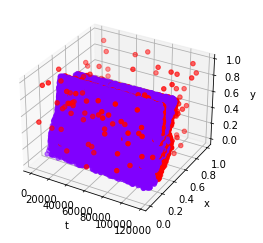

In [259]:
opt = {
    "h5": "/lzh/datasets/DVS/ASL-DVS/asl_dvs.h5",
    "labels": "/lzh/datasets/DVS/ASL-DVS/train.json",
    "sample_fn": "all",
    "sample_num": 1024,
}

dataset = EventsClsDataset(opt)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data = next(iter(dataloader))
events, gt, key = data["events"], data["gt"], data["key"]
# im = get_events_visuals(events)
# plt.imshow(im, cmap="gray")
# plt.draw()
get_events_visuals_3d(events)